### Installation

`conda install bioconductor-genomicranges bioconductor-summarizedexperiment -y`  

`R`  
`devtools::install_github("caleblareau/BuenColors")`

### Import packages

In [1]:
library(GenomicRanges)
library(SummarizedExperiment)
library(data.table)
library(dplyr)
library(BuenColors)
library(Matrix)

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Loading required package: S4Ve

### Preprocess

`bsub < count_reads_peaks_erisone.sh`

In [2]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 5335

In [ ]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 97998  5335

In [5]:
df_regions = read.csv("../../input/atac_v1_pbmc_5k_peaks.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)

[1] 97998     3

In [7]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [8]:
head(peaknames)

[1] "chr1_10244_10510"   "chr1_237575_237942" "chr1_565098_565554"
[4] "chr1_569172_569645" "chr1_713421_715095" "chr1_752386_753061"

In [9]:
head(sapply(strsplit(files,'\\.'),'[', 2))

[1] "AAACGAAAGCGCAATG-1" "AAACGAAAGGGTATCG-1" "AAACGAAAGTAACATG-1"
[4] "AAACGAAAGTTACACC-1" "AAACGAACAGAGATGC-1" "AAACGAACATGCTATG-1"

In [10]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 2)
rownames(datafr) = peaknames

In [11]:
datafr[1:3,1:3]

,AAACGAAAGCGCAATG-1,AAACGAAAGGGTATCG-1,AAACGAAAGTAACATG-1
chr1_10244_10510,1,0,1
chr1_237575_237942,0,0,0
chr1_565098_565554,0,0,6


In [12]:
dim(datafr)

[1] 97998  5335

In [13]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

### Obtain Feature Matrix

In [14]:
start_time <- Sys.time()

In [15]:
set.seed(2019)

In [16]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [17]:
# import counts
counts <- data.matrix(datafr)

In [18]:
dim(counts)
counts[1:3,1:3]

[1] 97998  5335

,AAACGAAAGCGCAATG-1,AAACGAAAGGGTATCG-1,AAACGAAAGTAACATG-1
chr1_10244_10510,1,0,1
chr1_237575_237942,0,0,0
chr1_565098_565554,0,0,6


In [19]:
# import gene bodies; restrict to TSS
gdf <- read.table("../../input/hg19/hg19-tss.bed", stringsAsFactors = FALSE)
dim(gdf)
gdf[1:3,1:3]

[1] 23938     5

V1,V2,V3
<chr>,<int>,<int>
chr19,58858171,58864865
chr19,58863335,58866549
chr10,52559168,52645435


In [20]:
tss <- data.frame(chr = gdf$V1, gene = gdf$V4, stringsAsFactors = FALSE)
tss$tss <-  ifelse(gdf$V5 == "+", gdf$V3, gdf$V2)
tss$start <- ifelse(tss$tss - 50000 > 0, tss$tss - 50000, 0)
tss$stop <- tss$tss + 50000
tss_idx <- makeGRangesFromDataFrame(tss, keep.extra.columns = TRUE)

In [21]:
# import ATAC peaks

adf <- data.frame(fread('../../input/atac_v1_pbmc_5k_peaks.bed'))
colnames(adf) <- c("chr", "start", "end")
adf$mp <- (adf$start + adf$end)/2
atacgranges <- makeGRangesFromDataFrame(adf, start.field = "mp", end.field = "mp")

In [22]:
# find overlap between ATAC peaks and Ranges linker
ov <- findOverlaps(atacgranges, tss_idx) #(query, subject)

Don't know how to automatically pick scale for object of type table. Defaulting to continuous.


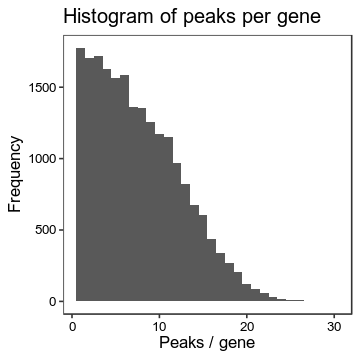

In [23]:
options(repr.plot.width=3, repr.plot.height=3)
# plot a histogram showing peaks per gene
p1 <- qplot(table(subjectHits(ov)), binwidth = 1) + theme(plot.subtitle = element_text(vjust = 1), 
                                                          plot.caption = element_text(vjust = 1)) +
  labs(title = "Histogram of peaks per gene",  x = "Peaks / gene", y="Frequency") + pretty_plot()
p1

In [24]:
# calculate distance decay for the weights
dist <- abs(mcols(tss_idx)$tss[subjectHits(ov)] - start(atacgranges)[queryHits(ov)])
exp_dist_model <- exp(-1*dist/5000)

In [25]:
# prepare an outcome matrix
m <- Matrix::sparseMatrix(i = c(queryHits(ov), length(atacgranges)),
                          j = c(subjectHits(ov), length(tss_idx)),
                          x = c(exp_dist_model,0))
colnames(m) <- gdf$V4 # gene name
m <- m[,which(Matrix::colSums(m) != 0)]

In [26]:
fm_genescoring <- data.matrix(t(m) %*% counts)

In [27]:
dim(fm_genescoring)
fm_genescoring[1:3,1:3]

[1] 20937  5335

,AAACGAAAGCGCAATG-1,AAACGAAAGGGTATCG-1,AAACGAAAGTAACATG-1
A1BG,0.0862008631,1.7756937,3.591624
A1BG-AS1,0.4582008458,0.4783511,1.365454
A2LD1,0.0003629473,0.0000000,0.000000


In [28]:
end_time <- Sys.time()

In [29]:
end_time - start_time

Time difference of 12.63262 secs

In [30]:
all(colnames(fm_genescoring) == rownames(metadata))

[1] TRUE

In [31]:
saveRDS(fm_genescoring, file = '../../output/feature_matrices/FM_GeneScoring_10xpbmc5k.rds')

In [32]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_GeneScoring/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.2-17               BuenColors_0.5.5           
 [3] ggplot2_3.2.0               MASS_7.3-51.4              
 [5] dplyr_0.8.3                 data.table_1.12.2          
 [7] SummarizedExperiment_1.12.0 DelayedArray_0.8.0         
 [9] 

In [33]:
save.image(file = 'GeneScoring_10xpbmc5k.RData')